# Introduction

Ces dernières années, le Covid a bousculé la vie des gens.
Pour accélérer le retour à la vie normale, fallait créer plusieurs méthodes pour détecter ce Virus. 
Les plus utilisés de nos jours sont les tests PCR, antigéniques et les auto-tests.

L'objectif de ce projet est d'utiliser l'image X-ray d'une personne pour déterminer s'elle a le covid, la pneumonia ou s'elle est saine.

Nous savons très bien que les réseaux de neurones sont le meilleur outil pour ce genre de tâches, c'est pour cela que nous allons implémenter, tester et comparer différentes architectures de réseaux de neurones.

# Préparation de l'environnement

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Tensorflow
import logging, os, shutil
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

# Préparation du jeu de données

Le jeu de données se compose des dossiers **Covid**, **Pneumonia** et **Normal**. Chaque dossier contient deux autres dossiers : 
* **images** qui contient les images X-ray de la catégorie correspondante (Covid-Pneumonia-Normal).
* **masks** qui contient les masques des poumons de chaque image (c'est-à-dire la position des poumons).

L'une des chose à faire est donc de tester l'effet du masque sur la précision des modèles.

La première chose à faire, est de déplacer et dupliquer mon jeu de données. 

Je vais créer : 
* un dossier **dataset_masked** dans lequel je vais mettre le jeu de données masqué.
* un dossier **dataset_unmasked** dans lequel je vais mettre le jeu de données non masqué.

In [5]:
# First thing : 
# Create the directories {dataset_masked / dataset_unmasked}
dataset_path = "./dataset"
dataset_masked_path = os.path.join(dataset_path, "dataset_masked")
dataset_unmasked_path = os.path.join(dataset_path, "dataset_unmasked")

os.makedirs(dataset_masked_path, exist_ok=True)
os.makedirs(dataset_unmasked_path, exist_ok=True)

Puis je déplace les dossiers Covid, Pneumonia et Normal dans **dataset_masked**

In [8]:
# Then : 
# Move the folders Covid, Pneumonia and Normal inside of dataset_masked
classes = ["Covid", "Pneumonia", "Normal"]
for c in classes:
    class_path = os.path.join(dataset_path, c)
    new_class_path = os.path.join(dataset_masked_path, c)
    shutil.move(class_path, new_class_path)

Maintenant, il faut dupliquer ces dossier à l'intérieur de **dataset_unmasked** 

In [8]:
# Create Covid, Pneumonia and Normal folders inside of 
# dataset_unmasked
for c in classes:
    class_path = os.path.join(dataset_unmasked_path, c)
    os.makedirs(class_path, exist_ok=True)

# Copy the corresponding images.
for c in classes:
    class_path = os.path.join(dataset_masked_path, c)
    images_path = os.path.join(class_path, "images")
    image_names = os.listdir(images_path)
    for image_name in image_names:
        image_path = os.path.join(images_path, image_name)
        new_image_path = os.path.join(dataset_unmasked_path, c, image_name)
        shutil.copy(image_path, new_image_path)

Voyons à quoi ressemble nos images et leurs masques.

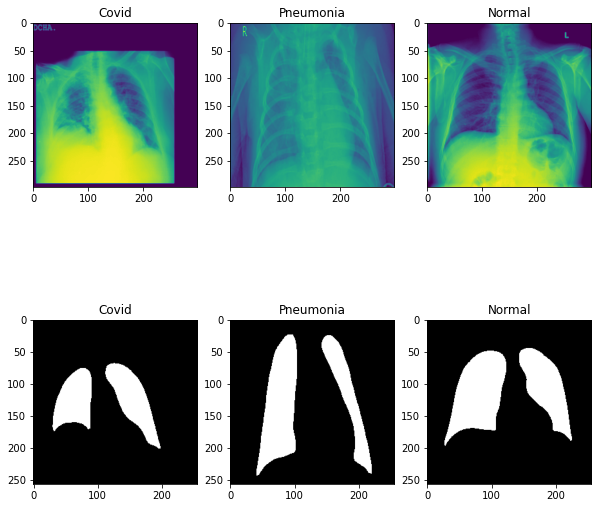

In [9]:
fig = plt.figure(figsize = (10,10))
for idx, c in enumerate(classes):
    class_path = os.path.join(dataset_masked_path, c)
    images_path = os.path.join(class_path, 'images')
    image_names = os.listdir(images_path)
    masks_path = os.path.join(class_path, 'masks')
    mask_names = os.listdir(masks_path)
    # Let's visualize the first image of each class.
    image_path = os.path.join(images_path, image_names[0])
    image = plt.imread(image_path)
    ax = plt.subplot(2,3, idx+1)
    ax.imshow(image)
    ax.set_title(c)
    # Let's visualize the first mask of each class.
    mask_path = os.path.join(masks_path, mask_names[0])
    mask = plt.imread(mask_path)
    ax = plt.subplot(2,3, idx+4)
    ax.imshow(mask)
    ax.set_title(c) 
plt.show()

Voyons à quoi ressemble les images masqués.

In [37]:
# First : Create a function that masks the images.
def mask_image(image, mask):
    """
    Mask an image.

    Arguments: 
    ----------
    image : the image that we want to mask, it can either be a numpy array or a PIL.Image
    mask  : the corresponding mask, it can either be a numpy array or a PIL.Image

    Returns : 
    ---------
    masked_image : the masked image, as a numpy array.
    """
    image = np.array(image.copy())
    mask = np.array(mask.copy())
    masked_image = np.ma.masked_where(mask == 0, image)
    return masked_image
    

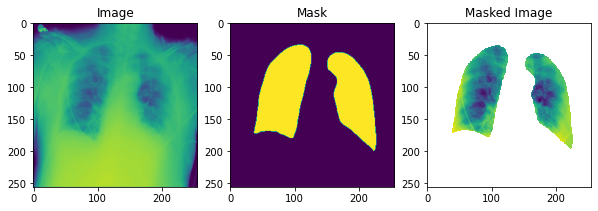

In [39]:
fig = plt.figure(figsize = (10,10))

# plot image
image_path = os.path.join(dataset_masked_path, "Covid", "images", "COVID-1.png")
image = np.array(Image.open(image_path).convert("L").resize((256,256)))
ax = plt.subplot(1,3,1)
ax.imshow(image)
ax.set_title("Image")

# plot mask
mask_path = os.path.join(dataset_masked_path, "Covid", "masks", "COVID-1.png")
mask = np.array(Image.open(mask_path).convert("L").resize((256,256))) 
ax = plt.subplot(1,3,2)
ax.imshow(mask)
ax.set_title("Mask")

# plot masked image
masked_image = mask_image(image, mask)
ax = plt.subplot(1,3,3)
ax.imshow(masked_image)
ax.set_title("Masked Image")

plt.show()


Dans le dossier **dataset_masked**, nous allons modifier les images en les masquants l'une après l'autre.
À chaque fois nous masquons une image nous allons l'enregistrer et supprimer le masque correspondant.